In [1]:
#각종 라이브러리를 임포트 해줍시다. 

%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import glob
from PIL import ExifTags

In [2]:
#각종 사용할 함수를 세팅합니다.

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    training_dir = "D:/training/"
    testing_dir = "D:/testing/"
    train_batch_size = 64
    train_number_epochs = 10

In [4]:
path = "D:\\testing\\**"
rot_img = []
for f in glob.glob(path, recursive=True):
    try:
        img = Image.open(f)
        exif_data = img._getexif()
        if exif_data[274] != 1:
            print(f, exif_data[274])
            rot_img.append(img)
    except:
        pass

D:\testing\10\0917013_SPI_01_0_00_0_01.jpg 6
D:\testing\8\0917011_SPI_01_0_00_0_01.jpg 6
D:\testing\9\0917012_SPI_01_0_00_0_01.jpg 6


In [31]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert

    def rotate(self, img):
        try:
            if img._getexif()[274] not in [1, 2]:
                orientation = img._getexif()[274]
                
                if orientation == 2:
                    img = img.transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 3:
                    img = img.rotate(180)

                elif orientation == 4:
                    img = img.rotate(180).transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 5:
                    img = img.rotate(-90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 6:
                    img = img.rotate(-90, expand=True)

                elif orientation == 7:
                    img = img.rotate(90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)
            
            return img
        except:
            return img
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        if img0._getexif() not in [1, 2]:
            img0 = self.rotate(img0)
        
        if img1._getexif() not in [1, 2]:
            img1 = self.rotate(img1)

        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [32]:
#training_dir 경로 안의 모든 파일을 폴더명과 함께 튜플로 저장
folder_dataset = dset.ImageFolder(root=Config.testing_dir)

In [33]:
folder_dataset[4]

(<PIL.Image.Image image mode=RGB size=4032x3024>, 1)

In [34]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.CenterCrop((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

In [35]:
siamese_dataset[0]

(tensor([[[0.9373, 0.8667, 0.8431,  ..., 0.6588, 0.4235, 0.3961],
          [0.9333, 0.8706, 0.8392,  ..., 0.6706, 0.4392, 0.3922],
          [0.9333, 0.8706, 0.8431,  ..., 0.6863, 0.4510, 0.3882],
          ...,
          [0.8078, 0.8078, 0.8118,  ..., 0.2157, 0.4235, 0.7529],
          [0.8078, 0.8078, 0.8118,  ..., 0.2196, 0.2627, 0.5216],
          [0.8118, 0.8196, 0.8118,  ..., 0.2353, 0.2549, 0.3020]]]),
 tensor([[[0.9373, 0.8667, 0.8431,  ..., 0.6588, 0.4235, 0.3961],
          [0.9333, 0.8706, 0.8392,  ..., 0.6706, 0.4392, 0.3922],
          [0.9333, 0.8706, 0.8431,  ..., 0.6863, 0.4510, 0.3882],
          ...,
          [0.8078, 0.8078, 0.8118,  ..., 0.2157, 0.4235, 0.7529],
          [0.8078, 0.8078, 0.8118,  ..., 0.2196, 0.2627, 0.5216],
          [0.8118, 0.8196, 0.8118,  ..., 0.2353, 0.2549, 0.3020]]]),
 tensor([0.]))

In [46]:
# 미니배치 생성기
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
# 미니배치 세트 생성
dataiter = iter(vis_dataloader)

In [47]:
dataiter

In [48]:
example_batch = next(dataiter)

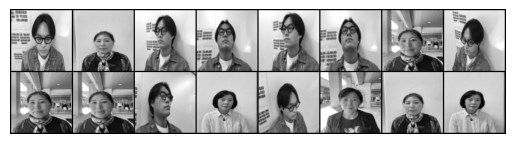

[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [49]:
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [50]:
torchvision.utils.make_grid(concatenated).shape

torch.Size([3, 206, 818])

In [51]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [52]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [53]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [54]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [55]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.9106425046920776

Epoch number 1
 Current loss 39.397193908691406

Epoch number 2
 Current loss 10.5162353515625

Epoch number 3
 Current loss 42.48372268676758

Epoch number 4
 Current loss 60.05062484741211

Epoch number 5
 Current loss 31.898082733154297

Epoch number 6
 Current loss 6.586874008178711

Epoch number 7
 Current loss 23.84450340270996

Epoch number 8
 Current loss 13.359434127807617

Epoch number 9
 Current loss 3.2342231273651123



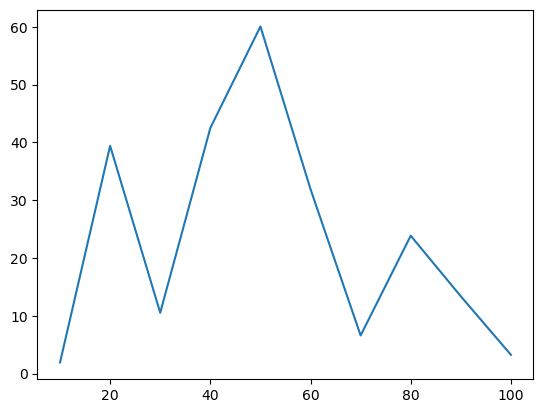

In [56]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

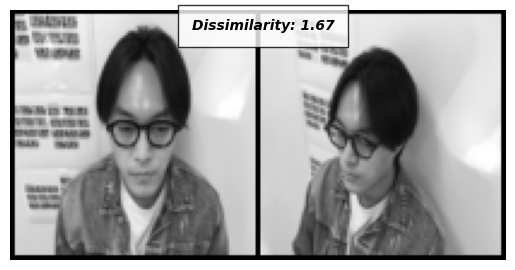

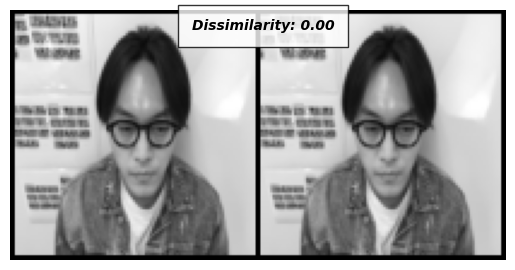

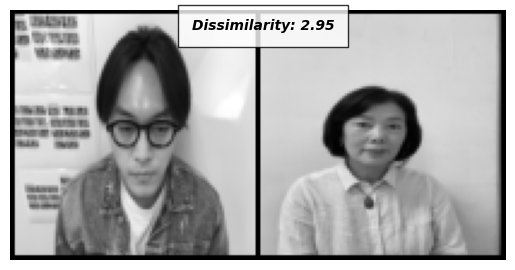

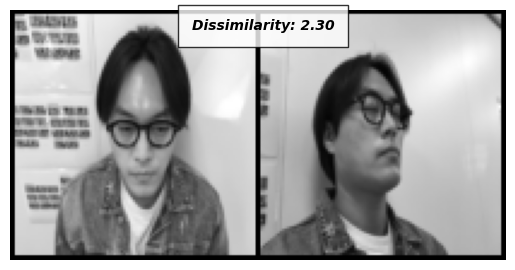

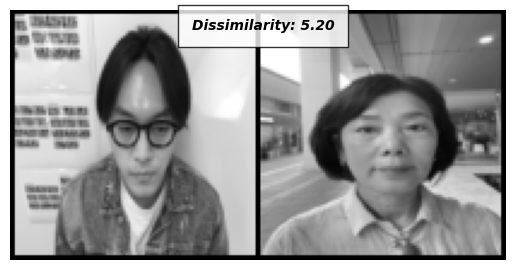

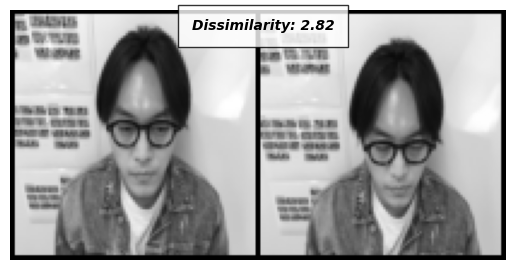

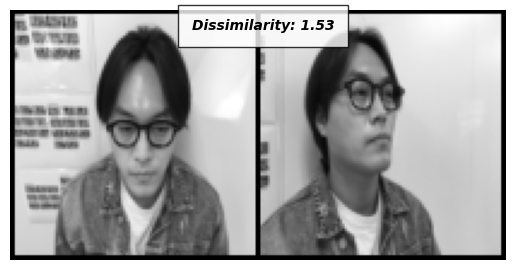

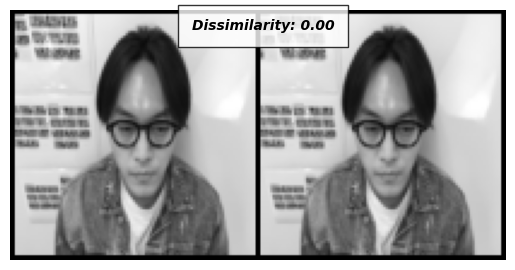

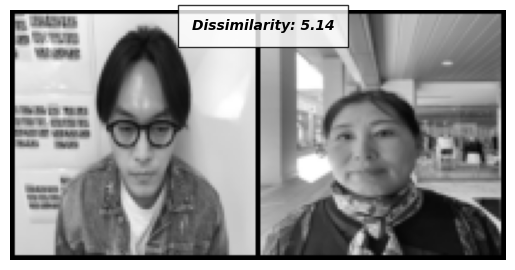

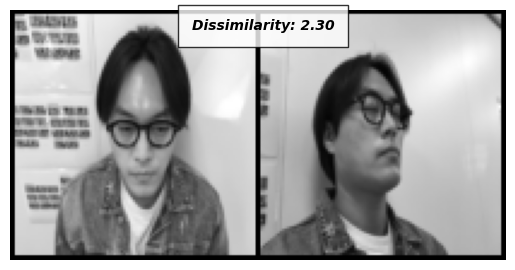

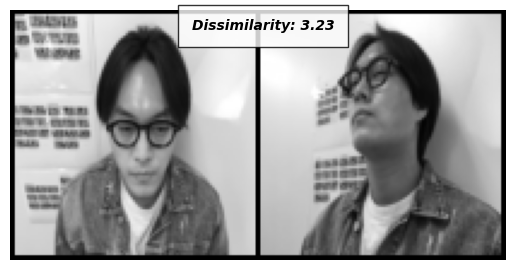

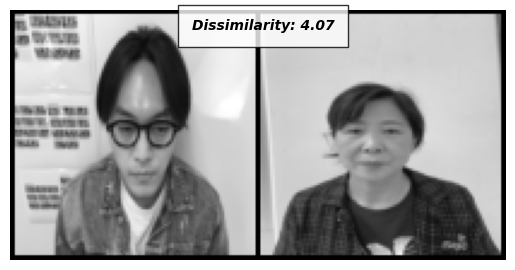

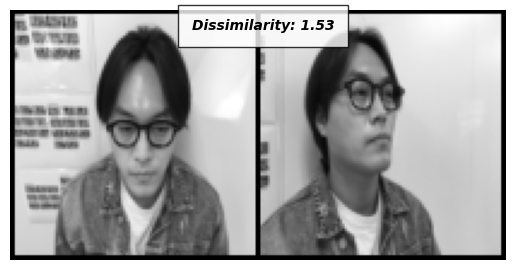

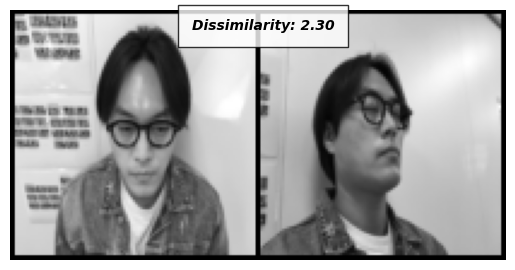

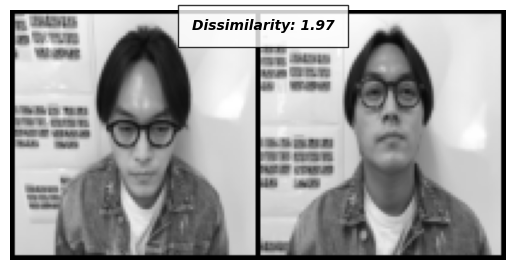

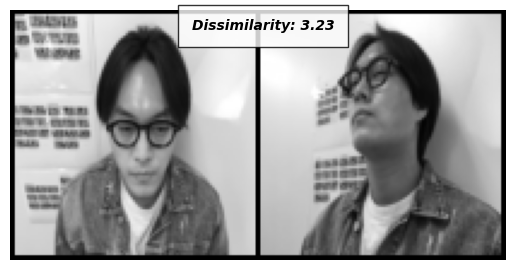

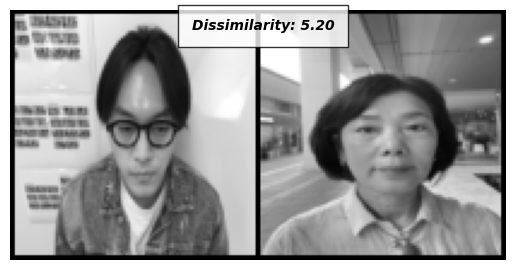

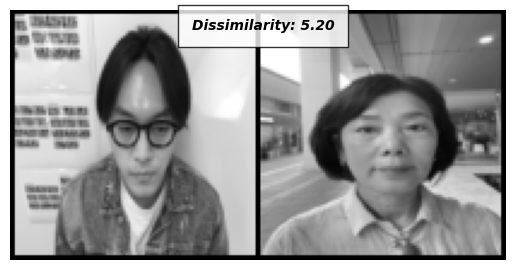

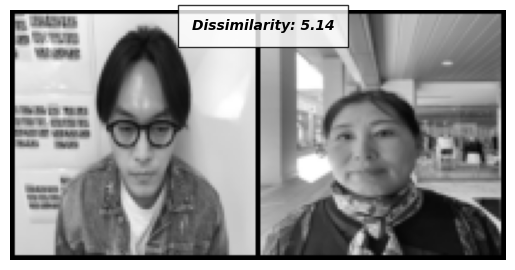

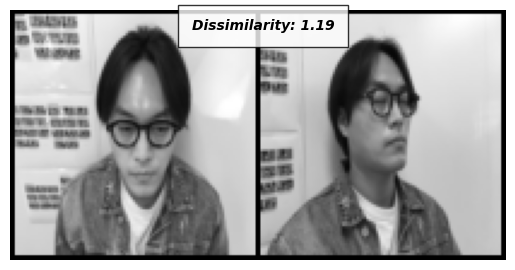

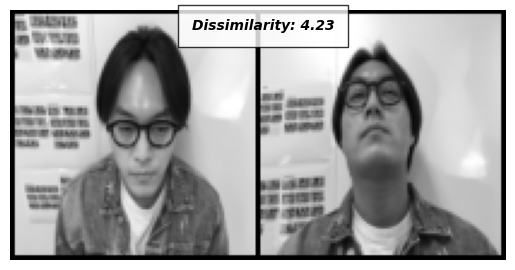

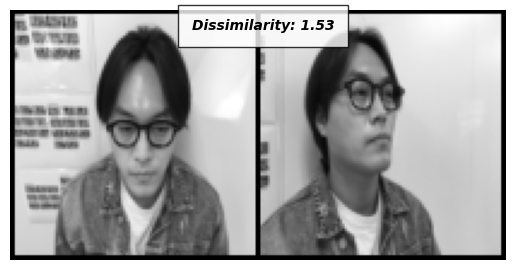

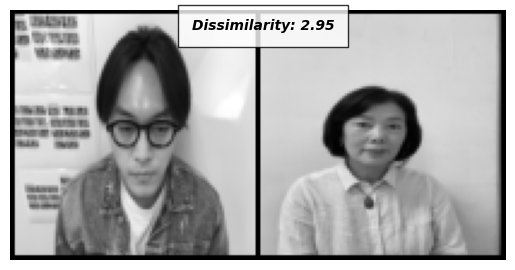

In [58]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(len(dataiter)-1):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))